## Оценка новой механики оплаты и аналитика активности пользователей на образовательной платформе

**Описание проекта:** Проект направлен на анализ результатов A/B-теста новой механики оплаты на образовательной платформе и оценку её эффективности по ключевым метрикам. Дополнительно исследуется активность пользователей в двух группах, а также отслеживаются основные метрики с помощью SQL-запросов. Все данные обрабатываются и визуализируются в Python для наглядного представления результатов.

**Цель:** Оценка эффективности и оптимизация образовательных продуктов через анализ ключевых метрик и проведение A/B-тестов.

**Технологический стек:** Python (pandas, scipy.stats, numpy, pandahouse, seaborn, matplotlib), SQL (ClickHouse), Jupyter Notebook, Git.

In [169]:
# Загрузим все необходимые нам библиотеки
import datetime
import pandas as pd
import numpy as np
import pandahouse as ph
import scipy.stats as ss
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency, chi2 

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

## A/B–тестирование 

### 1.1 Условие

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 
Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных имеется 4 csv-файла:

- groups.csv – файл с информацией о принадлежности пользователя к контрольной 
или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv – файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [170]:
# Подгрузим все файлы и допишем описание этих файлов из задания
# Так же сразу проверим на наличие Nan значений, типы данных, и количество значений

In [171]:
groups = pd.read_csv('Проект_2_groups.csv', sep=';')
group_add = pd.read_csv('Проект_2_group_add.csv')
activ_studs = pd.read_csv('Проект_2_active_studs.csv')
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

In [172]:
# ДФ с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
# (А – контроль, B – целевая группа) 
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [173]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [174]:
# дополнительный ДФ с пользователями, который прислали спустя 2 дня после передачи данных
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [175]:
group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [176]:
# ДФ с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
activ_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [177]:
activ_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [178]:
# ДФ с информацией об оплатах пользователей в дни проведения эксперимента. 
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [179]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [180]:
# Как видим, пропущенных значений нет, типы данных также соотвестуют своим значениям.

In [181]:
# Так же проверим на наличие дубликатов

print(f'groups - Всего значений: {groups["id"].count()}, из них уникальных: {groups["id"].nunique()}')
print(f"group_add - Всего значений: {group_add['id'].count()}, из них уникальных: {group_add['id'].nunique()}")
print(f'activ_studs - Всего значений: {activ_studs["student_id"].count()}, из них уникальных: {activ_studs["student_id"].nunique()}')
print(f'checks - Всего значений: {checks["student_id"].count()}, из них уникальных: {checks["student_id"].nunique()}')

groups - Всего значений: 74484, из них уникальных: 74484
group_add - Всего значений: 92, из них уникальных: 92
activ_studs - Всего значений: 8341, из них уникальных: 8341
checks - Всего значений: 541, из них уникальных: 541


In [182]:
# Соединим пользователей, которые добавились во 2ой день с изначальным списком

groups = pd.concat([groups, group_add])
print(f'groups - Всего значений: {groups["id"].count()}, из них уникальных: {groups["id"].nunique()}')

groups - Всего значений: 74576, из них уникальных: 74576


In [183]:
# Получаем датафрейм в котором все пользователи уникальные и не повторяются

full_df = groups.merge(activ_studs, how='left', left_on='id', right_on='student_id')
full_df = full_df.merge(checks, how='left', left_on='id', right_on='student_id')
full_df.head()

,id,grp,student_id_x,student_id_y,rev
0,1489,B,NaN,NaN,NaN
1,1627,A,1627.0,1627.0,990.0
2,1768,B,NaN,NaN,NaN
3,1783,B,NaN,NaN,NaN
4,1794,A,NaN,NaN,NaN


In [184]:
full_df = full_df.rename(columns={'student_id_x':'activ_studs','student_id_y':'check_studs'})

In [185]:
# Для начала отсечем пользователей, которые не заходили в дни эксперимента, тк мы не знаем как они бы себя повели.
# Соответственно результат мог быть другой, но в нашем случае они будут мешать 
# и могут повлиять на показатели статистики

full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           74576 non-null  int64  
 1   grp          74576 non-null  object 
 2   activ_studs  8341 non-null   float64
 3   check_studs  541 non-null    float64
 4   rev          541 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.4+ MB


In [186]:
# Проверим наличие статуса активности студента, тех кто совершал платежи
full_df.dropna(subset=['check_studs']).head()

,id,grp,activ_studs,check_studs,rev
1,1627,A,1627.0,1627.0,990.0
39,3185,B,NaN,3185.0,690.0
121,25973,B,NaN,25973.0,690.0
125,26280,B,NaN,26280.0,690.0
220,100300,B,100300.0,100300.0,990.0


In [187]:
# Возникает проблема: пользователи которые совершили оплату, не отображаются в колонке с пользователями которые 
# заходили в дни эксперимента на платформу

# Логика: Если услуга оплачивалсь -> пользователь посещал платформу

In [188]:
df_full = full_df
df_full['activ_studs'] = df_full['activ_studs'].fillna(df_full['check_studs'])
df_full = df_full.dropna(subset=['activ_studs'])

In [189]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8490 entries, 1 to 74562
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           8490 non-null   int64  
 1   grp          8490 non-null   object 
 2   activ_studs  8490 non-null   float64
 3   check_studs  541 non-null    float64
 4   rev          541 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 398.0+ KB


In [190]:
# Меняем значения c NaN на 0, для дальнейшей обработки данных
df_full['rev'] = df_full['rev'].fillna(0)

# Добавим колонку с целевым действием (оплатой), если оплата была - 1, если нет - 0
df_full['action'] = df_full['rev'].apply(lambda x: 1 if x != 0 else 0)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [191]:
# Проверяем, что все правильно сделали
df_full.query('action == 1 and rev == 0')

,id,grp,activ_studs,check_studs,rev,action


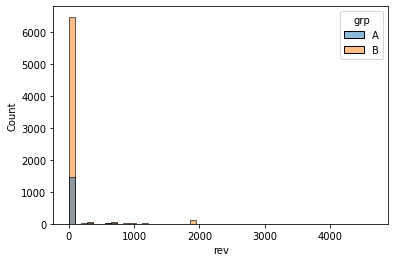

In [192]:
# Посмотрим на расперделение данных в группах

df_group = df_full.groupby(['id', 'grp'], as_index=False).agg({'rev':'mean'}).round(2)
sns.histplot(df_group, x='rev', hue='grp', bins=50)

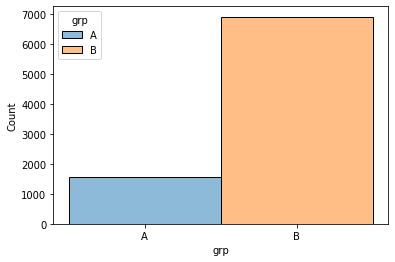

In [193]:
# так же посмотрим отношение группы А к группе В
sns.histplot(df_group, x='grp', hue='grp', bins=100)

In [194]:
# В полне ожидаемный результат, 
# тк всего пользователей заходивших в даты эксперимента порядка 8 000, а те кто делали покупки не больше 600

Тк распределение у нас ненормальное для проверки гипотез будем использовать критерий **хи-квадрата** (для проверки конверсии, тк при расчете конверсии у нас 2 категориальных переменных: группа А и В, и совершение платежа 1 и 0) и **тест Манна-Уитни** (для проверки среднего чека и ARPU). Можно было бы воспользоваться методом Boostrap, но для простого сравнения двух выборок по медиане тест Манна-Уитни будет более быстрым и эффективным.

In [195]:
# Создадим сводную таблицу для проверки гипотезы

cr_df = df_full.pivot_table(index=['grp','action'], aggfunc={'id':'count'}).rename(columns={'id':'count_users'})
cr_df = cr_df.pivot_table(index='grp', columns='action', values='count_users')
cr_df

action,0,1
grp,,
A,1460,107
B,6489,434


In [196]:
# Создаем колонку с конверсией каждой группы
cr_df['all'] = cr_df[0] + cr_df[1]
cr_df['CR'] = np.round(((cr_df[1] / cr_df['all'])*100),2)
cr_df

action,0,1,all,CR
grp,,,,
A,1460,107,1567,6.83
B,6489,434,6923,6.27


In [197]:
# Проверим гипотезу:
# H0 - Новый алгоритм никак не влияет на конверсию пользователей
# H1 - Новый алгоритм имеет статистически значимый эффект

observed = [[cr_df[1]['A'], cr_df[0]['A']],[cr_df[1]['B'], cr_df[0]['B']]]

stat, p, dof, expected = chi2_contingency(observed)

print(f"Статистика хи-квадрат: {stat}")
print(f"p-значение: {p}")

Статистика хи-квадрат: 0.579666003588264
p-значение: 0.4464432666411111


In [198]:
# Проверяем значение статистики с табличным значением распределения хи-квадрата

prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


#### Вывод о конверсии:

Тк p-value > 0.05, то у нас нет оснований отклонять нулевую гипотезу. А значит мы можем предположить что различие в конверсиях между группами можно считать случайным.

In [199]:
# Посчитаем ARPU
# Это сумма revenue на количество пользователей, которые могли сделать, 
# а могли и не сделать транзакцию в конкретный период.

arpu = df_full
arpu = arpu.groupby('grp', as_index=False).agg({'rev':'sum','id':'nunique'})
arpu['arpu'] = arpu['rev'] / arpu['id']
arpu

,grp,rev,id,arpu
0,A,92096.0000,1567,58.772176
1,B,481230.0036,6923,69.511773


In [200]:
# Гипотезы: 
# H0 - Новая механика оплаты услуг никак не повлияла на  метрику ARPU
# H1 - Новая механика имеет статистически значимый эффект на метрику ARPU

control_group = df_full.query('grp == "A"')['rev']
test_group = df_full.query('grp == "B"')['rev']

# Проведение теста Манна-Уитни
statistic, p_value = mannwhitneyu(control_group, test_group, alternative='two-sided')

print("U-статистика:", statistic)
print("p-value:", p_value)

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу, распределения различаются.")
else:
    print("Не можем отвергнуть нулевую гипотезу, распределения не различаются.")

U-статистика: 5449155.0
p-value: 0.5005924615057726
Не можем отвергнуть нулевую гипотезу, распределения не различаются.


#### Вывод о ARPU:
Такой высокий p-value (0.50) указывает на отсутствие статистически значимых различий в выручке между контрольной и тестовой группами. Соответственно, новая механика оплаты никак не влияет на средний чек на пользователя

In [201]:
# Посчитаем среднюю выручку
# Это сумма rev на количество всех транзакций за конкретный период

mean = df_full
mean = mean.query('rev > 0').groupby('grp', as_index=False).agg({'rev':'mean'})

mean

,grp,rev
0,A,860.710280
1,B,1108.824893


In [202]:
# Гипотезы: 
# H0 - Новая механика оплаты услуг никак не повлияла на средний чек
# H1 - Новая механика имеет статистически значимый эффект на средний чек

control_group_mean = df_full.query('grp == "A" and rev > 0')['rev']
test_group_mean = df_full.query('grp == "B" and rev > 0')['rev']
#Проведение теста Манна-Уитни
statistic, p_value = mannwhitneyu(control_group_mean, test_group_mean, alternative='two-sided')

print("U-статистика:", statistic)
print("p-value:", p_value)

# Интерпретация
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу, распределения различаются.")
else:
    print("Не можем отвергнуть нулевую гипотезу, распределения не различаются.")

U-статистика: 17862.0
p-value: 0.00019316054996380152
Отвергаем нулевую гипотезу, распределения различаются.


#### Вывод о среднем чеке:
Тк p-value < 0.05, то мы отвеграем нулевую гипотезу. Значит новая механика повлияла на средний чек пользователя

### Общий вывод: ###

Новая механика оплаты, судя по результатам, не улучшила общую конверсию и не повлияла на ARPU.
Однако она увеличила средний чек среди тех, кто совершает покупки, что может свидетельствовать о том, что покупающие пользователи стали тратить больше, когда использовали новую механику оплаты.

Поскольку конверсия и ARPU не изменились, это значит, что общая выручка на пользователя осталась прежней, и просто увеличивать средний чек без увеличения числа покупающих пользователей не приведет к значимому росту общей выручки.

Предположу что нужно провести дополнительный анализ, чтобы понять, какие факторы могли привести к увеличению среднего чека.

На основе текущих данных, новая механика оплаты не оказывает стат значимого эффекта на такие метрики как конверсия и ARPU. Ее внедрение на всех пользователей, возможно, преждевременно. Однако, если цель — повысить средний чек, новая механика может быть полезной для сегментов пользователей, склонных к более высоким тратам.

    

## SQL

#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. 
Найдем очень усердных студентов, которые хотя бы раз за текущий месяц правильно решили 20 заданий.

#### 2.1.2 Задача

Дана таблица default.peas:

Название атрибута|Тип атрибута|Смысловое значение
-----------------|------------|-----------------------------------------
st_id |int |ID ученика
timest|timestamp|Время решения карточки
correct|bool|Правильно ли решена горошина?
subject|text|Дисциплина, в которой находится горошина


Необходимо написать оптимальный запрос, который даст информацию 
о количестве очень усердных студентов.

### 2.2 Оптимизация воронки

#### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: 
студент может решить бесплатно лишь 30 задач в день. 
Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. 
Команда провела эксперимент, где был протестирован новый экран оплаты.

#### 2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs:

Название атрибута|Тип атрибута|Смысловое значение
-----------------|------------|----------------------------------------
st_id|int|ID ученика
test_grp|text|Метка ученика в данном эксперименте

и default.final_project_check:

Название атрибута|Тип атрибута|Смысловое значение
-----------------|------------|--------------------
st_id|int |ID ученика
sale_time|timestamp|Время покупки
money|int|Цена, по которой приобрели данный курс
subject|text |

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

**Все данные находятся в табличном виде в ClickHouse**

In [120]:
# Подключимся к базе данных ClickHouse

connection_default = {'host': 'https://clickhouse.lab.karpov.courses/',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [121]:
# Напишем запрос, чтобы посмотреть на данные
w = '''
    SELECT 
        st_id,
        toDateTime(timest) as timest, --Чтобы читался формат даты с миллисекундами
        correct,
        subject
    FROM 
        {db}.peas
    '''
# отправляем запрос и записываем результат в пандасовский датафрейм
w_test = ph.read_clickhouse(query=w, connection=connection_default)
w_test.head()

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability


In [122]:
# Посмотрим минимальную и максимальную дату, чтобы понимать в каких временным рамках мы находимся
print(f'Минимальнная дата {w_test.timest.min()}')
print(f'Максимальная дата {w_test.timest.max()}')

Минимальнная дата 2021-10-30 13:00:00
Максимальная дата 2021-10-31 17:29:52


In [123]:
# Делаем вывод, что данные представлены в рамках одного дня. 

In [124]:
diligent_students = '''
    SELECT COUNT(DISTINCT(st_id)) as diligent_students_count
    FROM (
    SELECT 
        st_id
    FROM {db}.peas
    WHERE correct = 1
    GROUP BY st_id
    HAVING count(*) >= 20
    ) as diligent_students
    '''
# отправляем запрос и записываем результат в пандасовский датафрейм
diligent_students = ph.read_clickhouse(query=diligent_students, connection=connection_default)
diligent_students

,diligent_students_count
0,136


Вывод: 
Тк по условию задачи требуется найти количество учеников, которые решили хотя бы 20 задач за месяц, а данные у нас всего за 2 дня, то мы смело берем всех учеников. Находим учеников, которые решили 20 задач и больше.

Ответ: 136 учеников

In [125]:
# Напишем запрос, чтобы посмотреть на данные для 2 задания
r = '''
    SELECT 
        p.st_id,
        toDateTime(timest) as timest, --Чтобы читался формат даты с миллисекундами
        correct,
        p.subject,
        s.test_grp,
        toDateTime(sale_time) as sale_time,
        money,
        f.subject
    FROM 
        {db}.peas as p
    LEFT JOIN {db}.studs as s
    ON p.st_id = s.st_id
    LEFT JOIN {db}.final_project_check as f
    ON p.st_id = f.st_id
    '''
# отправляем запрос и записываем результат в пандасовский датафрейм
r_test = ph.read_clickhouse(query=r, connection=connection_default)
r_test.head(15)

,p.st_id,timest,correct,p.subject,s.test_grp,sale_time,money,f.subject
0,100379,2021-10-30 13:32:29,1,Theory of probability,pilot,1970-01-01 03:00:00,0,
1,100379,2021-10-30 14:11:19,0,Vizualization,pilot,1970-01-01 03:00:00,0,
2,100379,2021-10-30 15:54:22,1,Theory of probability,pilot,1970-01-01 03:00:00,0,
3,100379,2021-10-30 16:44:50,1,Vizualization,pilot,1970-01-01 03:00:00,0,
4,100379,2021-10-30 17:15:05,1,Theory of probability,pilot,1970-01-01 03:00:00,0,
5,100379,2021-10-30 18:02:37,1,Theory of probability,pilot,1970-01-01 03:00:00,0,
6,100379,2021-10-30 18:17:25,1,Vizualization,pilot,1970-01-01 03:00:00,0,
7,100379,2021-10-30 18:32:26,0,Theory of probability,pilot,1970-01-01 03:00:00,0,
8,100379,2021-10-30 19:19:33,1,Vizualization,pilot,1970-01-01 03:00:00,0,
9,100379,2021-10-30 19:28:03,1,Theory of probability,pilot,1970-01-01 03:00:00,0,


In [126]:
# Напишем запросы для каждой метрики

# ARPU = общи доход / общее кол-во польз

arpu = '''
    SELECT 
        s.test_grp as groups,
        ROUND((sum(money) / count(distinct p.st_id)),2) as ARPU
    FROM 
        {db}.peas as p
        LEFT JOIN {db}.studs as s ON p.st_id = s.st_id
        LEFT JOIN {db}.final_project_check as f ON p.st_id = f.st_id
    GROUP BY s.test_grp
    '''
# отправляем запрос и записываем результат в пандасовский датафрейм
arpu_df = ph.read_clickhouse(query=arpu, connection=connection_default)
arpu_df.head(15)

,groups,ARPU
0,control,358666.67
1,pilot,1088461.54


In [127]:
# ARPAU = общий доход / кол-во активных польз

arpau = '''
    WITH active_users as 
    (
    SELECT 
        s.test_grp as groups, 
        COUNT(DISTINCT p.st_id) as count_active_users
    FROM 
        {db}.peas as p
        LEFT JOIN {db}.studs as s ON p.st_id = s.st_id
        LEFT JOIN {db}.final_project_check as f ON p.st_id = f.st_id
    WHERE correct = 1
    GROUP BY s.test_grp
    HAVING count(*) >= 10
    
    ), 
    revenue as 
    (
    SELECT 
        s.test_grp as groups, 
        sum(money) as revenue
    FROM 
        {db}.peas as p
        LEFT JOIN {db}.studs as s ON p.st_id = s.st_id
        LEFT JOIN {db}.final_project_check as f ON p.st_id = f.st_id
    GROUP BY s.test_grp
    ) -- В данном СТЕ считаем общий доход
    
    SELECT 
        au.groups,
        ROUND((revenue / count_active_users),2) as ARPAU 
    FROM 
        active_users as au
        LEFT JOIN revenue as r ON au.groups = r.groups
    '''
# отправляем запрос и записываем результат в пандасовский датафрейм
arpau_df = ph.read_clickhouse(query=arpau, connection=connection_default)
arpau_df.head(15)

,groups,ARPAU
0,control,363067.48
1,pilot,1096126.76


In [128]:
# CR в покупку = количество польз совершихших покупку / общ. кол-во польз * 100%

CR_in_orders = '''
    SELECT 
        s.test_grp as groups,
        round(((COUNT(DISTINCT CASE 
                                WHEN money > 0 THEN p.st_id 
                                END) / COUNT(DISTINCT p.st_id))*100),2) as CR_in_orders
    FROM 
        {db}.peas as p
        LEFT JOIN {db}.studs as s ON p.st_id = s.st_id
        LEFT JOIN {db}.final_project_check as f ON p.st_id = f.st_id
    GROUP BY s.test_grp
    '''
# отправляем запрос и записываем результат в пандасовский датафрейм
CR_in_orders = ph.read_clickhouse(query=CR_in_orders, connection=connection_default)
CR_in_orders.head(15)

,groups,CR_in_orders
0,control,9.09
1,pilot,20.98


In [129]:
# СR активного пользователя в покупку = кол-во активных польз совершихших покупку / кол-во активных польз. * 100%

CR_acvite_users_in_orders = '''
    SELECT 
        s.test_grp as groups, 
        round(((COUNT(DISTINCT CASE 
                                WHEN money > 0 THEN p.st_id 
                                END) / COUNT(DISTINCT p.st_id))*100),2) as CR_acvite_users_in_orders
    FROM 
        {db}.peas as p
        LEFT JOIN {db}.studs as s ON p.st_id = s.st_id
        LEFT JOIN {db}.final_project_check as f ON p.st_id = f.st_id
    WHERE correct = 1
    GROUP BY s.test_grp
    HAVING count(*) >= 10
    '''
# отправляем запрос и записываем результат в пандасовский датафрейм
CR_acvite_users_in_orders = ph.read_clickhouse(query=CR_acvite_users_in_orders, connection=connection_default)
CR_acvite_users_in_orders.head(15)    

,groups,CR_acvite_users_in_orders
0,control,9.20
1,pilot,21.13


In [130]:
# CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике = 
# кол-во польз, активных по математике и купивших курс по математике /
# кол-во польз, активных по математике * 100%


CR_acvite_users_in_math = '''
    SELECT 
    s.test_grp as groups, 
    ROUND((COUNT(DISTINCT CASE 
                            WHEN money > 0 THEN p.st_id 
                            END) / COUNT(DISTINCT p.st_id)*100),2)as CR_acvite_users_in_math
    FROM 
        {db}.peas as p
        LEFT JOIN {db}.studs as s ON p.st_id = s.st_id
        LEFT JOIN {db}.final_project_check as f ON p.st_id = f.st_id
    WHERE correct = 1 AND p.subject = 'Math'
    GROUP BY s.test_grp
    HAVING count(*) >= 2
    '''
# отправляем запрос и записываем результат в пандасовский датафрейм
CR_acvite_users_in_math = ph.read_clickhouse(query=CR_acvite_users_in_math, connection=connection_default)
CR_acvite_users_in_math.head(15)   

,groups,CR_acvite_users_in_math
0,control,11.76
1,pilot,13.64


In [47]:
# Оптимизируем запросы и объединим все наши запросы в один запрос с СТЕ

full_request = '''
WITH total_sum_users_buy_and_count_users as 
( -- СТЕ с группами, общей суммой покупок, количеством клиентов, и кол-вом клиентов купившие полный доступ
    SELECT 
        s.test_grp as groups,
        SUM(money) as total_sum,
        COUNT(DISTINCT p.st_id) AS count_users,
        COUNT(DISTINCT CASE WHEN money > 0 THEN p.st_id END) as users_buy
    FROM 
        {db}.peas as p
        LEFT JOIN {db}.studs as s ON p.st_id = s.st_id
        LEFT JOIN {db}.final_project_check as f ON p.st_id = f.st_id
    GROUP BY s.test_grp
), 

active_users_and_users_buy_course as 
( -- СТЕ с активными пользователями и с активными пользователями, которые купили полный доступ
    SELECT 
        s.test_grp as groups, 
        COUNT(DISTINCT p.st_id) as count_active_users,
        COUNT(DISTINCT CASE WHEN money > 0 THEN p.st_id END) as users_buy_course
    FROM 
        {db}.peas as p
        LEFT JOIN {db}.studs as s ON p.st_id = s.st_id
        LEFT JOIN {db}.final_project_check as f ON p.st_id = f.st_id
    WHERE correct = 1
    GROUP BY s.test_grp
    HAVING count(*) >= 10
),

CR_active_users_in_math as 
( -- СТЕ с активными пользователями по математике, а также активные пользователи по математике, которые купили полный доступ
    SELECT 
        s.test_grp as groups, 
        COUNT(DISTINCT CASE WHEN money > 0 THEN p.st_id END) AS users_buy_math,
        COUNT(DISTINCT p.st_id) AS acvite_users_in_math
    FROM 
        {db}.peas as p
        LEFT JOIN {db}.studs as s ON p.st_id = s.st_id
        LEFT JOIN {db}.final_project_check as f ON p.st_id = f.st_id
    WHERE correct = 1 AND p.subject = 'Math'
    GROUP BY s.test_grp
    HAVING count(*) >= 2
)

SELECT
    a.groups AS groups,
    ROUND((a.total_sum / a.count_users),2) AS arpu,
    ROUND((a.total_sum / au.count_active_users),2) AS arpau,
    ROUND((a.users_buy / a.count_users)*100,2) AS CR_in_orders,
    ROUND((au.users_buy_course / au.count_active_users)*100,2) AS CR_acvite_users_in_orders,
    ROUND((CRauim.users_buy_math / CRauim.acvite_users_in_math)*100,2) as CR_active_users_in_math
FROM total_sum_users_buy_and_count_users AS a
    LEFT JOIN active_users_and_users_buy_course AS au ON a.groups = au.groups
    LEFT JOIN CR_active_users_in_math AS CRauim ON a.groups = CRauim.groups;
'''
# отправляем запрос и записываем результат в пандасовский датафрейм
full_request = ph.read_clickhouse(query=full_request, connection=connection_default)
full_request.head()

,groups,arpu,arpau,CR_in_orders,CR_acvite_users_in_orders,CR_active_users_in_math
0,control,358666.67,363067.48,9.09,9.20,11.76
1,pilot,1088461.54,1096126.76,20.98,21.13,13.64


## Python
### 3.1 Задача

Реализовать функцию, которая будет автоматически подгружать информацию 
из дополнительного файла groups_add.csv (заголовки могут отличаться) 
и на основании дополнительных параметров пересчитывать метрики.
Реализовать функцию, которая будет строить графики по получаемым метрикам.

In [48]:
# Допустить что у нас те же файлы что и в 1 задании
# напишем под них функции

In [49]:
groups = pd.read_csv('Проект_2_groups.csv', sep=';')
group_add = pd.read_csv('Проект_2_group_add.csv')
activ_studs = pd.read_csv('Проект_2_active_studs.csv')
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

In [167]:
# Напишем функцию, которая будет подгружать информацию из дополнительного файла и перпесчитывать метрики
def uploading_additional_data(main_csv,add_csv):
    
    # Алгоритм обработки данных как в первом задании
    add_csv.columns.values[[0, 1]] = ['id', 'grp'] # переименовываем столбцы
    add_csv = pd.concat([main_csv, add_csv]) # соединяем с изначальным датасетом
    
    # Мерджим с остальными необходимыми датасетами, переименовываем колонки, для дальшейней работы 
    full_df = add_csv.merge(activ_studs, how='left', left_on='id', right_on='student_id') 
    full_df = full_df.merge(checks, how='left', left_on='id', right_on='student_id') 
    full_df = full_df.rename(columns={'student_id_x':'activ_studs','student_id_y':'check_studs'}) 
    
    # Удаляем пользователей, которых не было на сайте в дни эксперимента
    df_full = full_df
    df_full['activ_studs'] = df_full['activ_studs'].fillna(df_full['check_studs'])
    df_full = df_full.dropna(subset=['activ_studs'])
    
    # Находим CR 
    cr = df_full
    cr['activ_studs'] = cr['activ_studs'].fillna(cr['check_studs'])
    cr = cr.dropna(subset=['activ_studs'])
    cr = cr.groupby('grp', as_index=False).agg({'rev':'count','id':'nunique'})
    cr['cr'] = round(((cr['rev'] / cr['id'])*100),2)
    
    # Находим ARPU
    arpu = df_full
    arpu = arpu.groupby('grp', as_index=False).agg({'rev':'sum','id':'nunique'})
    arpu['arpu'] = arpu['rev'] / arpu['id']
    
    # Находим средний чек
    mean = df_full.groupby('grp', as_index=False)['rev'].mean()
    
    # В отдельные переменные сохраняем значения каждой из групп
    cr_A = cr.values[0][3]
    cr_B = cr.values[1][3]
    
    arpu_A = arpu.values[0][3]
    arpu_B = arpu.values[1][3]
    
    mean_A = mean.values[0][1]
    mean_B = mean.values[1][1]
    
    # Выведем информацию что метрики посчитались
    
    print(f'''Значение метрик
Конверсия для контрольной группы (А): {cr_A} %
Конверсия для тестовой группы (В): {cr_B} %
    
Средний доход на одного пользователя для контрольной группы (А): {round((arpu_A),2)}
Средний доход на одного пользователя для тестовой группы (В): {round((arpu_B),2)}

Средняя выручка для контрольной группы (А): {round((mean_A),2)}
Средняя выручка для тестовой группы (В): {round((mean_B),2)}''')
    
    # Сохраняем словарь с метриками
    metricks =  { 'Group': ['A', 'B'],
                  'CR':[cr_A, cr_B],
                  'ARPU':[arpu_A, arpu_B],
                  'Mean_rev':[mean_A, mean_B]
                }
    # Добавим дату, чтобы наш датасет с группами и юзерами сохранялся с датой, 
    # и была информация какой файл последний, если это потребуется
    day = datetime.date.today()
    add_csv.to_csv(f'{day}_main.csv')
    return metricks


# Напишем функцию, которая будет брать метрики и выводить визуализацию по ним, 
# заодно она будет выводить текстовую информацию
def visualizes(uploading_additional_data, metricks = ['CR', 'ARPU', 'Mean_rev']):
    
    # Преобразовываем словарь в ДатаФрейм
    df = pd.DataFrame(uploading_additional_data)
    
    # Проходимся по аргументу с метриками
    for columns in metricks:
        
        plt.subplots(figsize=(5, 5))
        plt.bar(df['Group'], df[columns], color='blue') 
        plt.title(f'График для метрики {columns}')
        plt.xlabel('Группа')
        plt.ylabel(columns)
        plt.tight_layout()
        plt.show()
        
# Удобность данной функции в том, что если появится потребность в других метриках, для которых данных достаточно,
# мы с легкостью можем добавить формулу расчета этой метрики и вывести ее показатели

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Значение метрик
Конверсия для контрольной группы (А): 6.83 %
Конверсия для тестовой группы (В): 6.28 %
    
Средний доход на одного пользователя для контрольной группы (А): 58.77
Средний доход на одного пользователя для тестовой группы (В): 69.79

Средняя выручка для контрольной группы (А): 860.71
Средняя выручка для тестовой группы (В): 1110.64
<class 'dict'>


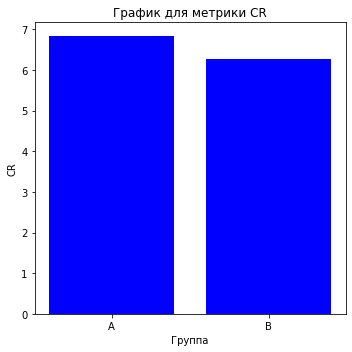

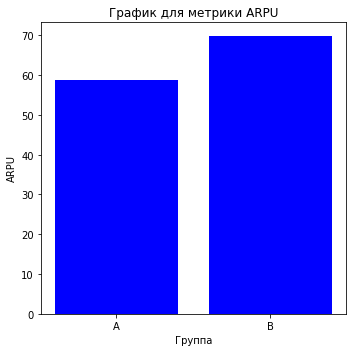

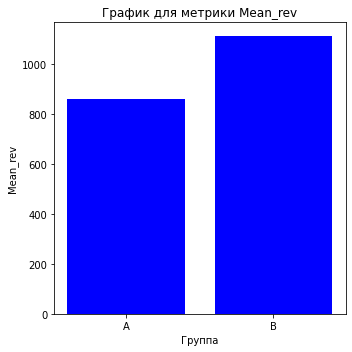

In [168]:
visualizes(uploading_additional_data(groups, group_add))

# Итоги проекта

### А/В-тест:
- Проведен анализ данных, обработка этих данных;
- Посчитаны основные метрики такие как CR, ARPU, Средний чек;
- Проверены, отличаются ли метрики в двух группах стат значимо.

#### По итогу А/В-теста принято решение пока не внедрять новую систему оплаты

### SQL:
- Написан запрос, который подключается к базе данных в ClickHouse;
- Запрос который считает количество активных учащихся;
- Запрос, который считает необходимые метрики

### Функция Python:
Написана функция, которая принимает 2 аргумента, с изначальной информацией, и с той, которую необходимо добавить. Внутри функции эти таблицы объединяются и мерджаться с таблицами для рассчета метрик. Далее данные обрабатываются, считаютяс метрики, выводится основная информация о значениях метрик, изначальные 2 датафрейма объединяются в один и сохраняюся с датой запуска функции. Возвращает словарь с метриками.

Вторая функция принимает на вход словарь, который вернула первая функция, и необязательный аргумент - метрики. По умолчанию визуализируются все 3 метрики - CR, ARPU, Средний чек. Также выводится информация, которая считалась в первой функции, это основная информация о значенях метрик в группах